In [3]:
'''This heavily borrows the example "English-to-Spanish translation with 
a sequence-to-sequence Transformer" by fchollet, from the keras github page, 
which you can find here: https://github.com/keras-team/keras-io/blob/master/examples/nlp/neural_machine_translation_with_transformer.py'''

import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

import matplotlib.pyplot as plt         #for visualizing

import pandas as pd
from bs4 import BeautifulSoup

#Here, we import a csv of parallel text from https://corpus.eduhk.hk/paraconc/
#besides some lines at the beginning and end, a typical line in this csv looks like
#the following: 
                #"Alice in Wonderland / 愛麗絲夢遊仙境In another moment down went Alice after 
                #it, never once considering how in the world she was to get out again.不一會
                #兒﹐愛麗絲也跟著鑽了進去﹐根本沒想過以後怎樣出來。"
    
data = pd.read_csv('parallel-results.csv')
data = data[:-1]

#to avoid having to work with pandas consistently, and to clean html tages from the text, 
#we make the following arrays
zh = []
eng = []
for i in range(0,len(data['eng-zh-html'])):
    eng.append(BeautifulSoup(data['eng-zh-html'][i]).find_all('td')[1].string)
    zh.append(BeautifulSoup(data['eng-zh-html'][i]).find_all('td')[2].string)
    
#then, pair the text
text_pairs = []

for i in range(0,10000):
    cur_eng = eng[i]
    cur_zh = zh[i]
    #the tokenizer will break on spaces, which are not naturally part of chinese text, so we add them
    #as well as start and end tokens for training
    cur_zh = "[start] " + " ".join([*cur_zh]) + " [end]" 
    text_pairs.append((cur_eng, cur_zh))
    
#now we make a train-test split
random.shuffle(text_pairs)
num_val_samples = int(0.2 * len(text_pairs))
num_train_samples = len(text_pairs) - num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : ]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} test pairs")

10000 total pairs
8000 training pairs
2000 test pairs


In [4]:
#vectorizing text:

#for english to be tokenized, it seems one approach is to strip punctuation and split on
#spaces. this is the standard vectorization and we leave it that way
#for chinese, since we inserted spaces we can also use the standard vectorization and
#tokenize every character, including punctuation
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64

eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
zh_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_zh_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
zh_vectorization.adapt(train_zh_texts)


#Formatting datasets. This is exactly as in the keras example:

def format_dataset(eng, zh):
    eng = eng_vectorization(eng)
    zh = zh_vectorization(zh)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": zh[:, :-1],
        },
        zh[:, 1:],
    )

def make_dataset(pairs):
    eng_texts, zh_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    zh_texts = list(zh_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, zh_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

2023-03-02 11:58:17.093397: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
#Defining the model. This is exactly as in the keras example:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

#then, the actual model using the classes defined above is

embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [6]:
#training the model: here, we add some callbacks compared with the keras example to monitor training

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
#checkpoint to save the best model
checkpoint = ModelCheckpoint(filepath="checkplz",
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

#decrease lr on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

callbacks = [checkpoint,reduce_lr]

epochs = 20  # This should be at least 30 for convergence

#reducing learning rate with adam
transformer.summary()
transformer.compile(
    loss="sparse_categorical_crossentropy", metrics=["accuracy"], 
    optimizer = "adam"
)

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks = callbacks)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

2023-03-02 12:05:19.228583: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: checkplz/assets


INFO:tensorflow:Assets written to: checkplz/assets


125/125 [==============================] - 424s 3s/step - loss: 5.0695 - accuracy: 0.1577 - val_loss: 4.1210 - val_accuracy: 0.2580 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 3.8195 - accuracy: 0.2862
Epoch 2: val_loss improved from 4.12100 to 3.69891, saving model to checkplz


INFO:tensorflow:Assets written to: checkplz/assets


INFO:tensorflow:Assets written to: checkplz/assets


125/125 [==============================] - 374s 3s/step - loss: 3.8195 - accuracy: 0.2862 - val_loss: 3.6989 - val_accuracy: 0.3015 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 3.4246 - accuracy: 0.3289
Epoch 3: val_loss improved from 3.69891 to 3.55299, saving model to checkplz


INFO:tensorflow:Assets written to: checkplz/assets


INFO:tensorflow:Assets written to: checkplz/assets


125/125 [==============================] - 387s 3s/step - loss: 3.4246 - accuracy: 0.3289 - val_loss: 3.5530 - val_accuracy: 0.3187 - lr: 0.0010
Epoch 4/20
125/125 [==============================] - ETA: 0s - loss: 3.1733 - accuracy: 0.3549
Epoch 4: val_loss improved from 3.55299 to 3.51500, saving model to checkplz


INFO:tensorflow:Assets written to: checkplz/assets


INFO:tensorflow:Assets written to: checkplz/assets


125/125 [==============================] - 301s 2s/step - loss: 3.1733 - accuracy: 0.3549 - val_loss: 3.5150 - val_accuracy: 0.3230 - lr: 0.0010
Epoch 5/20
125/125 [==============================] - ETA: 0s - loss: 2.9678 - accuracy: 0.3783
Epoch 5: val_loss improved from 3.51500 to 3.48010, saving model to checkplz


INFO:tensorflow:Assets written to: checkplz/assets


INFO:tensorflow:Assets written to: checkplz/assets


125/125 [==============================] - 296s 2s/step - loss: 2.9678 - accuracy: 0.3783 - val_loss: 3.4801 - val_accuracy: 0.3297 - lr: 0.0010
Epoch 6/20
125/125 [==============================] - ETA: 0s - loss: 2.7853 - accuracy: 0.4027
Epoch 6: val_loss did not improve from 3.48010
125/125 [==============================] - 275s 2s/step - loss: 2.7853 - accuracy: 0.4027 - val_loss: 3.5119 - val_accuracy: 0.3320 - lr: 0.0010
Epoch 7/20
125/125 [==============================] - ETA: 0s - loss: 2.6076 - accuracy: 0.4261
Epoch 7: val_loss did not improve from 3.48010
125/125 [==============================] - 280s 2s/step - loss: 2.6076 - accuracy: 0.4261 - val_loss: 3.5266 - val_accuracy: 0.3384 - lr: 0.0010
Epoch 8/20
125/125 [==============================] - ETA: 0s - loss: 2.4232 - accuracy: 0.4542
Epoch 8: val_loss did not improve from 3.48010
125/125 [==============================] - 279s 2s/step - loss: 2.4232 - accuracy: 0.4542 - val_loss: 3.5953 - val_accuracy: 0.3382 - lr

In [9]:
#decoding sentences: this is exactly as in the keras example

zh_vocab = zh_vectorization.get_vocabulary()
zh_index_lookup = dict(zip(range(len(zh_vocab)), zh_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = zh_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = zh_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

val_eng_texts = [pair[0] for pair in val_pairs]

for _ in range(10):
    input_sentence = random.choice(val_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence)
    print(translated)

Accounting practices change too rapidly to be frozen in legislation.
[start] 霹 靂 要 求 實 行 ， 以 相 當 處 理 由 於 公 司 的 法 律 制
- and Mithers himself came into the room where I was waiting for her - THERE'S a man!
[start] 米 考 伯 太 太 就 出 了 個 房 間 挨 得 很 長 的 那 個 侍 者
(h) providing alternative forms for the constitution of a company.
[start] 週 內 部 份 基 本 法 例 如 同 時 內 ； end  。 過 章 end end
'Gee up, Dobbin,
[start] 往 前 跑 哇 ， 達 賓 end  過 。 end end 。 end 。 end end 。 end
I was in the middle state between sleeping and waking, either then or immediately afterwards;
[start] 然 而 我 是 在 中 央 有 惡 量 學 校 裏 ， 也 不 過 功 課 之
'No,' I answered.
[start] “ 不 ， ” 我 答 道 。 end  。 end 。 end 。 end 人 end 。 end
"My dear, I think I am dying."
[start] 我 親 愛 的 是 個 她 親 愛 的 。 end  生 了 。 她 道 end 。
What ravages I committed on my favourite authors in the course of my interpretation of them, I am not in a condition to say, and should be very unwilling to know;
[start] 我 自 己 也 忍 受 人 ， 懷 著 我 傷 心 ， 把 懷 著 懷 著 我
After which he borrowed a shilling of m

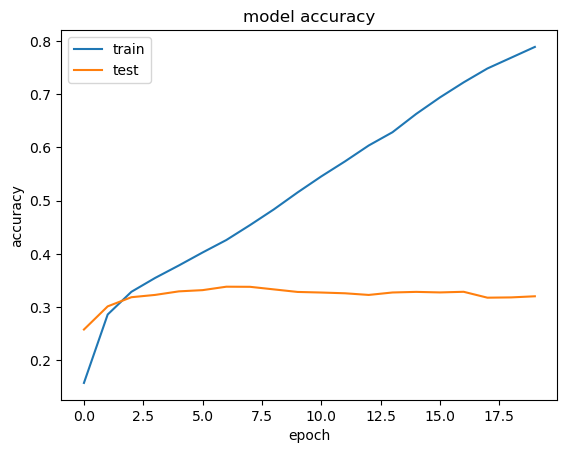

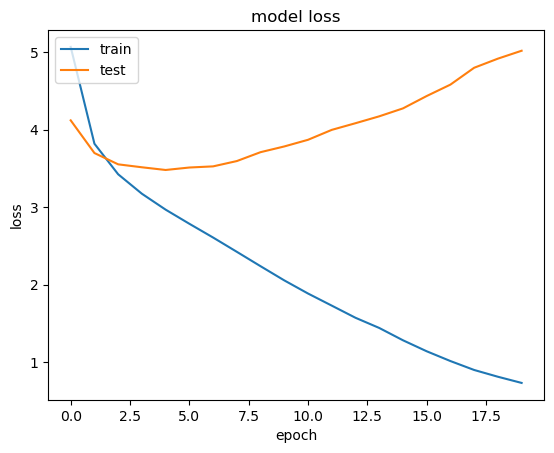

In [10]:
#plotting metrics

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
decode_sequence('what is that?')

'[start] “ 那 麼 吃 飯 嗎 ？ end  。 end 。 end end 。 。 end end 。 end'

In [13]:
decode_sequence('who are you?')

'[start] 你 真 抱 歉 意 。 end  道 。 end end 。 end 。 。 end end 。 end'